In [1]:
from IPython.display import HTML
from ibm_watson import AssistantV2
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import pandas as pd    
import json
import time
from tqdm import tqdm
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
from datetime import date

In [2]:
authenticator = IAMAuthenticator('API-KEY-GOES-HERE')
assistant = AssistantV2(
    version='2020-04-01',
    authenticator = authenticator
)
assistant.set_service_url('URL-GOES-HERE')
assistant_id = 'ASSISTANT-ID-GOES-HERE'

In [3]:
ResponseList = []
IntentList = []
QuestionList = []
ConfidenceList = []
ExpectedList = []

#For the Historic scores file
HistoricMatchConfidence = []
HistoricUnmatchConfidence = []
HistoricAverageConfidence = []
HistoricCorrectResponse = []
HistoricLowConfidence = []
HistoricDate = []

today = date.today()


RegressionFile = pd.read_csv("Regression.csv")
RegressionLog = pd.read_csv("RegressionLog.csv")


In [4]:
#Load files into useable lists for the regression file


QuestionList = RegressionFile['Question'].tolist()
ExpectedList = RegressionFile['Expected'].tolist()
ScoreList = RegressionFile['Previous Score'].tolist()

#Load in historic results.
HistoricMatchConfidence = RegressionLog['Match Confidence']
HistoricUnmatchConfidence = RegressionLog['Unmatched Confidence']
HistoricAverageConfidence = RegressionLog['Average Confidence']
HistoricCorrectResponse = RegressionLog['Correct Response %']
HistoricLowConfidence = RegressionLog['Low Confidence']
HistoricDate = RegressionLog['Date']

"pd.set_option('display.max_rows', 5)\npd.set_option('display.max_columns', 500)\npd.set_option('display.width', 1000)"

In [5]:
 
def Sender():
    response = assistant.message_stateless(
    assistant_id,
    input={
        'message_type': 'text',
        'text': x,
     'options': {
            'return_context': True
        }
    },
    context={
        'skills': {
            'main skill': {
                'user_defined': {
                    'ConfidenceTester': 'Yes'
                }
            }
        }
    }
).get_result()
    pbar.update(1) #Updates the progressbar
    IntentList.append((response['context']['skills']['main skill']['user_defined']['Intent']['intent']))
    ConfidenceList.append((response['context']['skills']['main skill']['user_defined']['Intent']['confidence']))


In [11]:

pbar = tqdm(total=len(QuestionList),desc="Percentage complete", unit='Questions processed') 
for x in QuestionList:
    Sender()
    pbar.update(1)
pbar.close()

Percentage complete: 6Questions processed [00:00, 12.71Questions processed/s]


Intent  Confidence
0     sites    0.220558
1  greeting    0.205047
2  greeting    0.478564


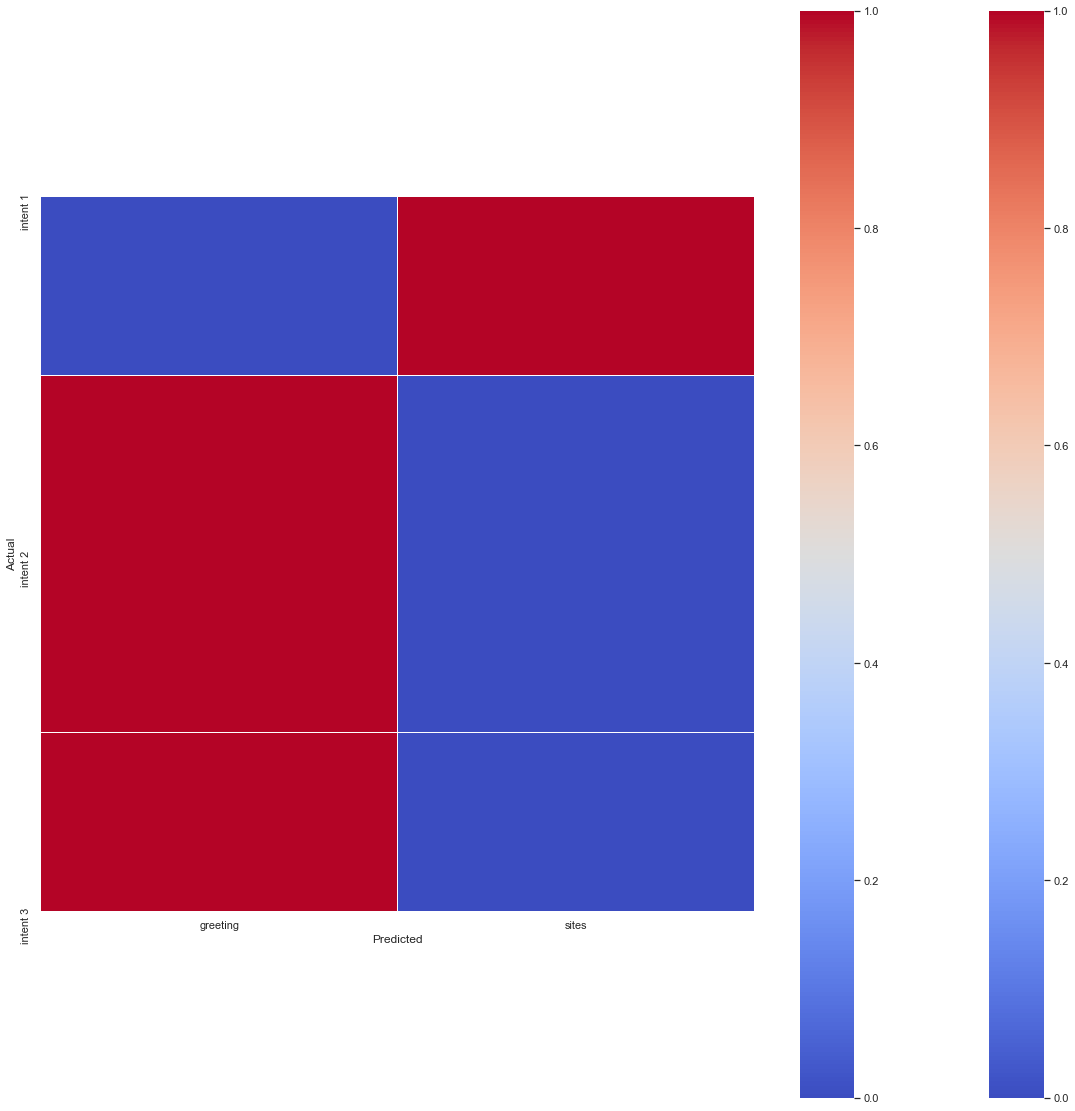

In [9]:
MatchList = []
ConfidenceChangeList = []

#Turn lists into one case so they're easy to match

IntentList = [item.lower() for item in IntentList] 
ExpectedList = [item.lower() for item in ExpectedList]


if len(IntentList) == len(ExpectedList):
    for i in range(len(IntentList)):
        if IntentList[i] == ExpectedList[i]:
         MatchList.append('Matched')
        else: 
         MatchList.append('Unmatched')

CorrectCount = MatchList.count("Matched")
IncorrectCount = MatchList.count("Unmatched")
LowconfidenceCount = IntentList.count('zlowconf')


Total = (CorrectCount + IncorrectCount)
Total = CorrectCount / Total
Total = round(Total * 100,2)


RegressionFile['MatchList'] = MatchList
RegressionFile['ConfidenceList'] = ConfidenceList
MatchedQuestion = RegressionFile[(RegressionFile['MatchList'] == 'Matched')]
UnmatchedQuestion = RegressionFile[(RegressionFile['MatchList'] == 'Unmatched')]
AverageForMatched = round(MatchedQuestion['ConfidenceList'].mean() * 100,2)
AverageForUnmatched = round(UnmatchedQuestion['ConfidenceList'].mean() *100,2)
AverageConfidence = round(RegressionFile['ConfidenceList'].mean() *100,2)

#Convert the data from floats to Strings
AverageForMatched = str(AverageForMatched)
AverageForUnmatched = str(AverageForUnmatched)
AverageConfidence = str(AverageConfidence)
Total = str(Total)
LowconfidenceCount = str(LowconfidenceCount)

LatestHistoricMatchConfidence = []
LatestHistoricUnmatchConfidence = []
LatestHistoricAverageConfidence = []
LatestHistoricCorrectResponse = []
LatestHistoricLowConfidence = []
LatestHistoricDate = []

LatestHistoricMatchConfidence.append(AverageForMatched)
LatestHistoricUnmatchConfidence.append(AverageForUnmatched)
LatestHistoricAverageConfidence.append(AverageConfidence)
LatestHistoricCorrectResponse.append(Total)
LatestHistoricDate.append(today)


LatestDict = {'Match Confidence': (LatestHistoricMatchConfidence),
              'Unmatched Confidence':(LatestHistoricUnmatchConfidence),
              'Average Confidence':(LatestHistoricAverageConfidence),
              'Correct Response %':(LatestHistoricCorrectResponse),
              'Low Confidence':(LowconfidenceCount),
              'Date':(LatestHistoricDate)   
} 

LatestDF = pd.DataFrame(LatestDict)

HistoricDict = { 'Match Confidence':(HistoricMatchConfidence),
                 'Unmatched Confidence':(HistoricUnmatchConfidence),
                 'Average Confidence':(HistoricAverageConfidence),
                 'Correct Response %':(HistoricCorrectResponse),
                 'Low Confidence':(HistoricLowConfidence),
                 'Date':(HistoricDate)
               }


HistoricDF = pd.DataFrame(HistoricDict)
JoinedDF = pd.concat([HistoricDF,LatestDF], join="inner")

JoinedDF.tail(5)

#Average per intent
LowConfidenceRemoved = IntentList
pd.set_option('display.max_rows', 500)

UniqueList = list(dict.fromkeys(IntentList))
AverageDict = {
    'Intent': IntentList,
    'Confidence': ConfidenceList
}

AverageDF = pd.DataFrame(AverageDict)
print(AverageDF)

MeanDF = AverageDF.groupby(['Intent']).mean()
IntentCountDF = AverageDF.groupby(['Intent']).count()


# # Create a Confusion Matrix


ConfusionMatrixData = {'y_Actual': LowConfidenceRemoved,
                       'y_Predicted': ExpectedList 
                         }

DFCM = pd.DataFrame(ConfusionMatrixData, columns=['y_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(DFCM['y_Predicted'], DFCM['y_Actual'], rownames=['Actual'], colnames=['Predicted'], normalize='index')
sns.set(rc={'figure.figsize':(20,20)})
confusionmat = sns.heatmap(confusion_matrix, cmap='coolwarm',linewidths=.2, square=True,)
plt.show(sns.heatmap(confusion_matrix, cmap='coolwarm',linewidths=.2, square=True))
fig = confusionmat.get_figure()
fig.savefig('ConfusionMatrix.png')

In [8]:
mydict = { 'Question':(QuestionList),
           'Expected':(ExpectedList),
           'Intent':(IntentList),
           'Confidence':(ConfidenceList),
           'Matched': (MatchList),
           'Previous Score':(ScoreList)
               }
finaldf = pd.DataFrame(mydict)
finaldf.to_csv('Regression.csv', index=False)


Historic = {'Match Confidence':(HistoricMatchConfidence),
            'Unmatched Confidence':(HistoricUnmatchConfidence),
            'Average Confidence':(HistoricAverageConfidence),
            'Correct Response %':(HistoricCorrectResponse),
            'Low Confidence':(HistoricLowConfidence),
            'Date':(HistoricDate)
               }

HistoricDF = pd.DataFrame(Historic)
RegressionLogDF = pd.concat([HistoricDF,LatestDF], join="inner")
RegressionLogDF.to_csv('RegressionLog.csv', index=False)